# CRCNS PFC2 Dataset
Spike with 96 channel LFP (PFC: 1-64, CA1: 65-96)

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/Lauren/Voytek/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
%matplotlib inline

# imports
import numpy as np
import scipy as sp
import h5py
import matplotlib.pyplot as plt

import neurodsp as ndsp
from scv_funcs import lfpca
from scv_funcs import utils
import pandas as pd
import pandas.plotting as pdplt

CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 13}
import matplotlib
matplotlib.rc('font', **font)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [50]:
def organize_spikes(spike_t, spike_ind, cell_info):
    # grab individual unit spike times
    spikes_cell = []
    for cell in cell_info:
        spikes_cell.append(spike_t[spike_ind==cell[0]])

    # combine units from the same shank
    spikes_shank = []
    shank_id = np.unique(cell_info[:,1]) 
    for sh in shank_id:
        spikes_shank.append(np.sort(np.concatenate([spikes_cell[i] for i in np.where(cell_info[:,1]==sh)[0]])))

    # combine units from the same area (PFC sh1-8 & CA1 sh9-12)
    spikes_area = []
    spikes_area.append(np.sort(np.concatenate([spikes_shank[sh] for sh in np.where(shank_id<=8)[0]])))
    spikes_area.append(np.sort(np.concatenate([spikes_shank[sh] for sh in np.where(shank_id>8)[0]])))
    
    return spikes_cell, spikes_shank, spikes_area

def get_win_timevec(t, nperseg, noverlap, alignment='left'):
    gen = utils.yield_sliding_window_ts(t, nperseg, noverlap)
    if alignment is 'left':
        tvec = [win[0] for win in gen]
    elif alignment is 'right':
        tvec = [win[-1] for win in gen]
    elif alignment is 'center':
        tvec = [win[int(len(win)/2)] for win in gen]
    return np.array(tvec)

def get_win_bp_stats(data, fs, filt_band, nperseg=1250, noverlap=0, N_cycles=7, filt_thr=0.05, N_skip=None, log_power=False, return_filt=False):
    sig_pwr, _, val_inds, ker_len = lfpca.compute_BP_HT(data,fs,filt_band,N_cycles,filt_thr)
    if N_skip is None:
        # default to filter kernel length
        skip_len = ker_len
    elif N_skip<1.:
        # if float less than 1, then take to be proportion of kernel length
        skip_len = int(ker_len*N_skip)
    else:
        # integer number skip
        skip_len = int(N_skip)
    
    win_pwr = []
    win_scv = []
    win_ksstat = []
    win_kspval = []
    gen = utils.yield_sliding_window_ts(sig_pwr, nperseg=nperseg, noverlap=noverlap)
    for win in gen:
        if np.any(np.isnan(win)):
            fill_val = np.NaN
            win_pwr.append(fill_val)
            win_scv.append(fill_val)
            win_ksstat.append(fill_val)
            win_kspval.append(fill_val)
        else:
            # compute power
            if log_power:
                win_pwr.append(np.log10(win[::skip_len]).mean())
            else:
                win_pwr.append(win[::skip_len].mean())
            # compute SCV
            win_scv.append(win[::skip_len].std()/win[::skip_len].mean())

            # compute KS test against fitted exponential
            _, ksst, kspv = lfpca.fit_test_exp(win[::skip_len])
            win_ksstat.append(ksst)
            win_kspval.append(kspv)
        
    if return_filt:
        return np.array([win_pwr,win_scv, win_ksstat, win_kspval]).T, sig_pwr, val_inds, ker_len
    else:
        return np.array([win_pwr,win_scv, win_ksstat, win_kspval]).T


def get_win_spk_stats(spk_t, spk_len, spk_rate=20000, bin_rate=1250, nperseg=1250, noverlap=0):
    bsp = utils.binarize_spiketime(spk_t, spk_len, spike_rate=spk_rate, bin_rate=bin_rate)
    slg = utils.yield_sliding_window_ts(bsp, nperseg=nperseg, noverlap=noverlap)
    fr, isi_mean, isi_cv = [], [], []    
    for i,win in enumerate(slg):
        fr.append(sum(win))
        if sum(win>0)>1:
            isi = np.diff(np.where(win)[0])
            isi_mean.append(isi.mean())
            isi_cv.append(isi.std()/isi.mean())
        else:
            isi_mean.append(0)
            isi_cv.append(0)
        
    return np.array(fr), np.array(isi_mean), np.array(isi_cv)

def get_pp_spk_stats(spk_t, spk_fs=20000, win_len=1., overlap_len=0., end_time=None):
    # point process sliding window computation
    slg = utils.yield_sliding_window_pp(spk_t, fs=spk_fs, win_len=win_len, overlap_len=overlap_len, end_time=end_time)
    fr, isi_mean, isi_cv = [],[],[]
    for i,win in enumerate(slg):
        # compute firing rate
        fr.append(len(win[0]))
        # if more than 1 spike, compute ISI stats
        if len(win[0])>1:
            isi = np.diff(win[0])
            isi_mean.append(isi.mean())
            isi_cv.append(isi.std()/isi.mean())
        else:
            isi_mean.append(0)
            isi_cv.append(0)

    return np.array(fr), np.array(isi_mean), np.array(isi_cv)

def compute_pairwise_corr(spkstats, lfpstats, sub_inds, corr_type='spearman', log_power=False, plot_matrix=False):
    fr,isi_cv = spkstats[sub_inds,0], spkstats[sub_inds,2]
    if log_power:
        pwr = lfpstats[sub_inds,:,0]
    else:
        pwr = np.log10(lfpstats[sub_inds,:,0])
    scv = lfpstats[sub_inds,:,1]
    ks_stat = lfpstats[sub_inds,:,2]
    
    num_freqs = pwr.shape[1]
    rho = np.zeros((5,5,num_freqs))
    for freq in range(num_freqs):
        df = pd.DataFrame(np.array([fr, isi_cv, pwr[:,freq], scv[:,freq], ks_stat[:,freq]]).T, columns=labels)
        corr = df.corr(method='spearman').as_matrix()
        rho[:,:,freq] = corr
        if plot_matrix:
            axes = pdplt.scatter_matrix(df, alpha=0.2, figsize=(7, 7), diagonal='kde');
            for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
                # label with correlation coefficient
                axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
    return rho

def plot_corrs(corr_mat,f1,f2,labels,YL=(-0.5,0.5)):
    plt.plot(corr_mat[f1,f2,:,:].T, '-o')
    num_chan = corr_mat.shape[-1]
    re_div = num_chan/3.*2.-0.5 # region division
    plt.xticks([re_div], ["PFC  |  CA1"])
    plt.ylim(YL)
    plt.plot([re_div,re_div], plt.ylim(), 'k--', alpha=0.5)
    plt.plot(plt.xlim(), [0,0], 'r--', alpha=0.5)
    plt.title(labels[f1]+' : '+labels[f2])

In [83]:
# load LFP data
datapaths = ['/Users/rdgao/Documents/data/CRCNS/pfc2/EE.049/EE.049',
             '/Users/rdgao/Documents/data/CRCNS/pfc2/EE.152/EE.152',
             '/Users/rdgao/Documents/data/CRCNS/pfc2/EE.196/EE.196',
             '/Users/rdgao/Documents/data/CRCNS/pfc2/FF.130/FF.130'
            ]
basefolder = datapaths[0]
lfp_file = basefolder+ '_LFP.mat'
try:
    lfp_struct = sp.io.loadmat(lfp_file, squeeze_me=True)
    print('MATFile')
    data = lfp_struct['lfp'][:96,:]
    t = lfp_struct['t']
    fs = lfp_struct['fs'] #1250
except:    
    hf = h5py.File(lfp_file, 'r')
    print('HDF5')
    data = np.array(hf.get('lfp'))[:96,:]
    t = np.array(hf.get('t'))
    fs = np.array(hf.get('fs'))

MATFile


In [84]:
# load spike data
spike_file = basefolder + '_Behavior.mat'
spike_struct = sp.io.loadmat(spike_file, squeeze_me=True)
cell_info = spike_struct['spikeph']
spike_ind = spike_struct['spikeind'] 
spike_t = spike_struct['spiket'] # 20kHz

# organize spikes into cells, shanks, and areas
spkt_c, spkt_sh, spkt_re = organize_spikes(spike_t, spike_ind, cell_info)
_, cells_per_shank = np.unique(cell_info[:,1], return_counts=True)

In [85]:
analysis_param = {'nperseg': 1250,
                 'noverlap': 0,
                 'spg_outlierpct': 2.,
                 'max_freq':200}

# initialize object with data and parameters
pfc_lfpca = lfpca.LFPCA(analysis_param)
pfc_lfpca.populate_ts_data(data[::4,:], fs) # take every 4th channel(2 per shank)

# compute all spectral attributes
pfc_lfpca.compute_all_spectral()

# compute KS-test fit against null exponential hypothesis
pfc_lfpca.compute_KS_expfit() # this takes a few minutes

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


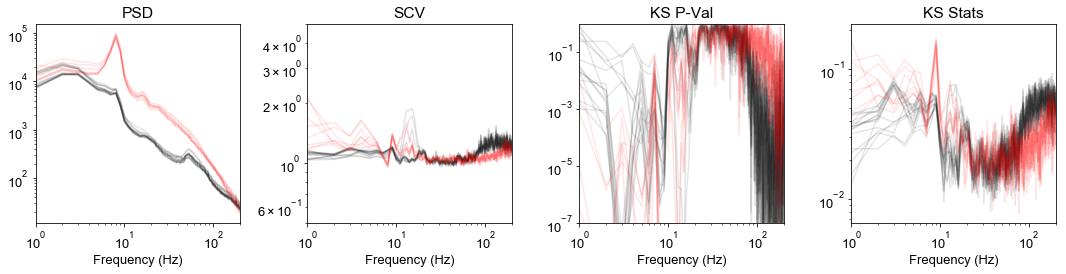

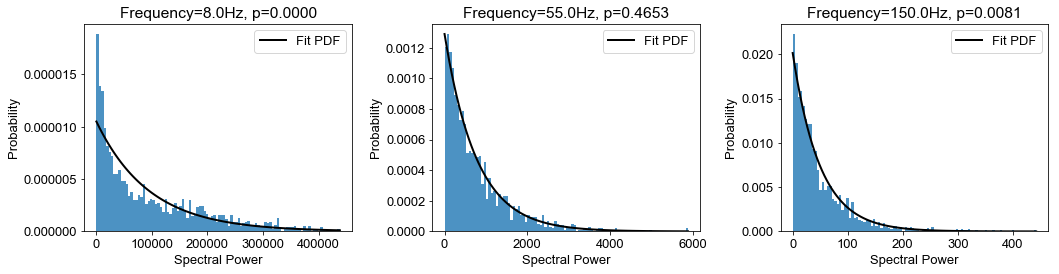

In [88]:
plt.figure(figsize=(15,4))
pfc_lfpca.plot_spectral(plot_mean=False, plot_chan=range(16))
pfc_lfpca.plot_spectral(plot_mean=False, plot_chan=range(16,24), plot_color='r')

plot_chan = 20
plot_freqs = [8,55,150]

plt.figure(figsize=(15,4))
for i,f in enumerate(plot_freqs):
    plt.subplot(1,3,i+1)
    pfc_lfpca.plot_expfit(chan=plot_chan, freq_ind=f)

plt.tight_layout()

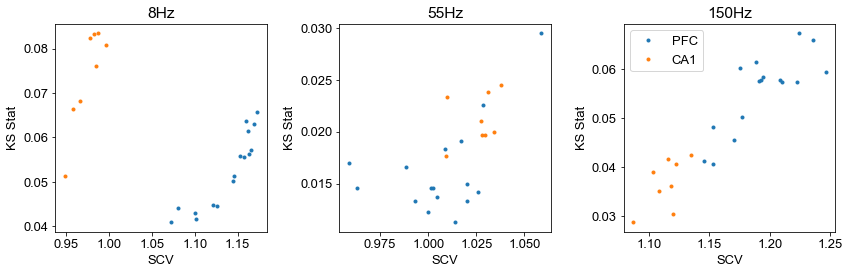

In [41]:
plt.figure(figsize=(12,4))
for i,f in enumerate([8, 55, 150]):
    plt.subplot(1,3,i+1)
    plt.plot(pfc_lfpca.scv[:16,f],pfc_lfpca.ks_stats[:16,f],'.', label='PFC')
    plt.plot(pfc_lfpca.scv[16:,f],pfc_lfpca.ks_stats[16:,f],'.', label='CA1')
    plt.xlabel('SCV')
    plt.ylabel('KS Stat')
    plt.title('%iHz'%pfc_lfpca.f_axis[f])
plt.legend()
plt.tight_layout()

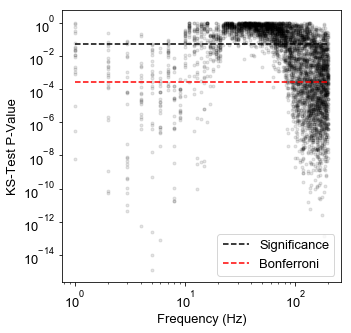

In [99]:
# plot
sig_alpha = 0.05
plt.figure(figsize=(5,5))
plt.loglog(pfc_lfpca.f_axis, pfc_lfpca.ks_pvals[:,:].T, 'k.', alpha=0.1)
plt.plot(pfc_lfpca.f_axis, np.ones_like(pfc_lfpca.f_axis)*sig_alpha, 'k--', label='Significance')
plt.plot(pfc_lfpca.f_axis, np.ones_like(pfc_lfpca.f_axis)*sig_alpha/len(pfc_lfpca.f_axis), 'r--', label='Bonferroni')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('KS-Test P-Value');

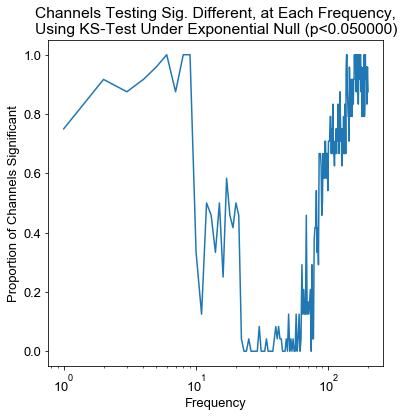

In [100]:
sig_thres = sig_alpha#/len(pfc_lfpca.f_axis)
plt.figure(figsize=(6,6))
plt.semilogx(pfc_lfpca.f_axis,np.sum(pfc_lfpca.ks_pvals<sig_thres,0)/pfc_lfpca.numchan )
plt.xlabel('Frequency')
plt.ylabel('Proportion of Channels Significant')
plt.title('Channels Testing Sig. Different, at Each Frequency,\nUsing KS-Test Under Exponential Null (p<%f)'%sig_thres);

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


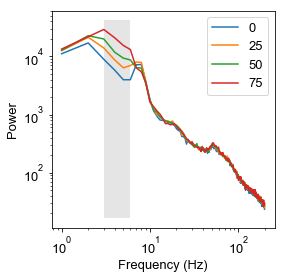

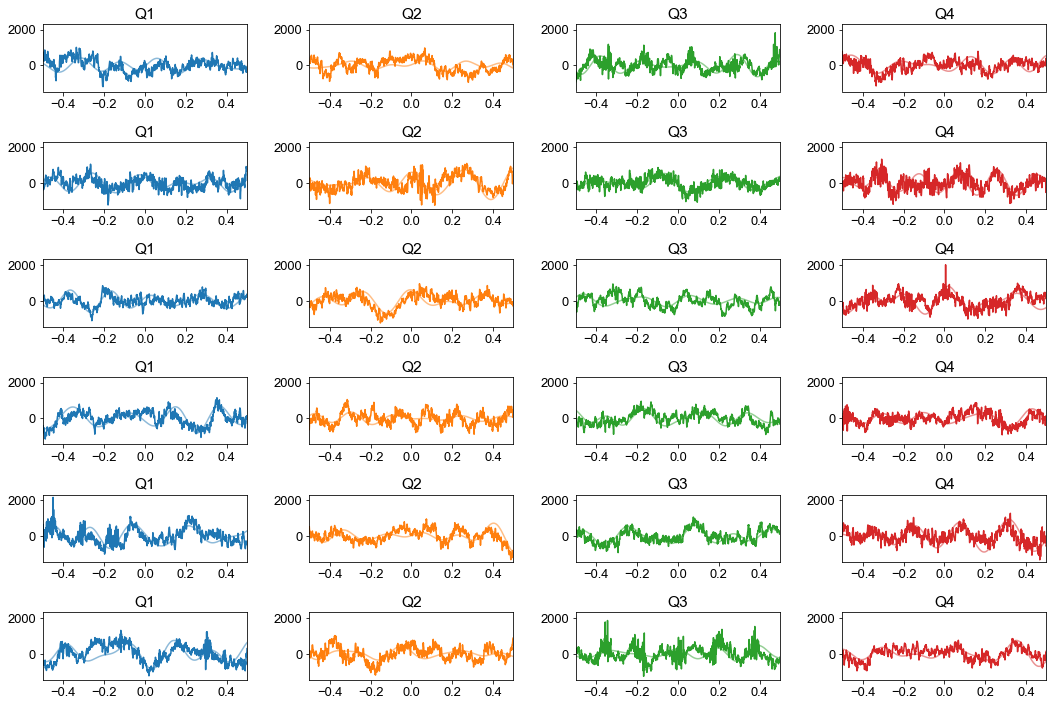

In [101]:
plot_chan = 0
rank_freqs = (3,6)

plt.figure(figsize=(4,4))
pwr_dgt, power_binned = utils.percentile_spectrogram(pfc_lfpca.spg[plot_chan,:,:], pfc_lfpca.f_axis, rank_freqs=rank_freqs, pct=range(0,100,25))
plt.figure(figsize=(15,10))
t_good = pfc_lfpca.t_axis[list(set(np.arange(len(pfc_lfpca.t_axis)))-set(pfc_lfpca.outlier_inds[plot_chan,:]))]
utils.plot_power_examples(pfc_lfpca.data[plot_chan,:], pfc_lfpca.fs, pfc_lfpca.t_axis, pwr_dgt, rank_freqs, N_cycles=7, power_adj=2)

# Spiking & LFP analysis
Spiking variables (for both single unit and population total):
- Total Spikes (Firing Rate, FR)
- ISI CV (Fano Factor, FF)
    
### STFT analysis (can limit to windows with trials)
Per-window:
- bandlimited power
Across-window:
- bandlimited power
- bandlimited SCV/KS stat

### Filter-Hilbert analysis
Rolling window: 
- power & power variability vs. FR & FF


### Example usage of functions

In [45]:
# 3 equivalent ways to compute firing rate (spikes per window)
# 1. binarize then slide as a binary time series
spk_t = spkt_re[1]
bsp = utils.binarize_spiketime(spk_t, data.shape[1], spike_rate=20000, bin_rate=1250)
slg = utils.yield_sliding_window_ts(bsp, nperseg=1250, noverlap=0)
fr = []
isicv = []
for i,win in enumerate(slg):
    fr.append(sum(win))
    if sum(win>0)>1:
        isi = np.diff(np.where(win)[0])
        isicv.append(isi.std()/isi.mean())
        
fr = np.array(fr)

# 2. binarize in the equivalent time window (though this cannot handle overlap)
bsp_fr = utils.binarize_spiketime(spk_t, int(data.shape[1]/1250+1), spike_rate=20000, bin_rate=1)

# 3. compute directly by sliding window over the spike times
slg = utils.yield_sliding_window_pp(spk_t, fs=20000, win_len=1., overlap_len=0.)
pp_fr = []
pp_isicv = []
for i,win in enumerate(slg): 
    pp_fr.append(len(win[0]))
    # also compute ISI CV
    if len(win[0])>1:
        isi = np.diff(win[0])
        pp_isicv.append(isi.std()/isi.mean())
    else:
        pp_isicv.append(0.)
        
pp_fr = np.array(pp_fr)
pp_isicv = np.array(pp_isicv)

# Compute time-resolved (filter-Hilbert) measures

In [47]:
nperseg= 1250
noverlap= int(nperseg/2)
N_skip=25
#filt_bands = [(4,12), (24,40), (150,200)]
filt_bands = [(0,4),(6,12),(14,20),(30,40),(50,70),(70,100),(150,200)]
t_win = get_win_timevec(t, nperseg=nperseg, noverlap=noverlap, alignment='center')

In [48]:
# compute spiking measures
spkstats_cell = np.zeros((len(spkt_c),len(t_win), 3)) # cell x time x stat
spkstats_shank = np.zeros((len(spkt_sh),len(t_win), 3))
spkstats_re = np.zeros((len(spkt_re),len(t_win), 3))

for cell in range(len(spkt_c)):
    spkstats_cell[cell,:,0],spkstats_cell[cell,:,0],spkstats_cell[cell,:,0] = get_pp_spk_stats(spkt_c[cell], win_len=nperseg/fs, overlap_len=noverlap/fs, end_time=t[-1])

for cell in range(len(spkt_sh)):
    spkstats_shank[cell,:,0],spkstats_shank[cell,:,1],spkstats_shank[cell,:,2] = get_pp_spk_stats(spkt_sh[cell], win_len=nperseg/fs, overlap_len=noverlap/fs, end_time=t[-1])

for cell in range(len(spkt_re)):
    spkstats_re[cell,:,0],spkstats_re[cell,:,1],spkstats_re[cell,:,2] = get_pp_spk_stats(spkt_re[cell], win_len=nperseg/fs, overlap_len=noverlap/fs, end_time=t[-1])

In [49]:
# compute LFP measures
sigpower_all = np.zeros((pfc_lfpca.data.shape[0], pfc_lfpca.data.shape[1], len(filt_bands)))
lfpstats_rw = np.zeros((pfc_lfpca.data.shape[0], len(t_win), len(filt_bands), 4))
lfpstats_summary = np.zeros((pfc_lfpca.data.shape[0], len(filt_bands), 4)) 
for chan in range(pfc_lfpca.data.shape[0]):
    print(chan)
    for ind, fb in enumerate(filt_bands):
        print(fb)
        lfpstats_rw[chan,:,ind,:], sigpower_all[chan,:,ind], val_inds, ker_len = get_win_bp_stats(pfc_lfpca.data[chan,:], fs, fb, nperseg=nperseg, noverlap=noverlap, N_cycles=5, filt_thr=0.05, N_skip=N_skip, return_filt=True)
        lfpstats_summary[chan,ind,0] = sigpower_all[chan,val_inds,ind][::int(ker_len*N_skip)].std()/sigpower_all[chan,val_inds,ind][::int(ker_len*N_skip)].mean()
        lfpstats_summary[chan,ind,1:] = lfpca.fit_test_exp(sigpower_all[chan,val_inds,ind][::int(ker_len*N_skip)])

0
(0, 4)
(6, 12)
(14, 20)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(30, 40)
(50, 70)
(70, 100)
(150, 200)
1
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
2
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
3
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
4
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
5
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
6
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
7
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
8
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
9
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
10
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
11
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
12
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
13
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
14
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(70, 100)
(150, 200)
15
(0, 4)
(6, 12)
(14, 20)
(30, 40)
(50, 70)
(

In [52]:
np.savez('../results/pfc2/EE049_filt.npz', 
         t_win=t_win, 
         spkstats_cell=spkstats_cell, 
         spkstats_re=spkstats_re, 
         spkstats_shank=spkstats_shank, 
         lfpstats_rw=lfpstats_rw, 
         lfpstats_summary=lfpstats_summary, 
         sigpower_all=sigpower_all, 
         nperseg=nperseg,
         noverlap=noverlap,
         N_skip=N_skip,
         filt_bands=filt_bands
        )

# Load results

In [24]:
data_loaded = np.load('../results/pfc2/EE049_filt.npz')
t_win = data_loaded['t_win']
spkstats_cell = data_loaded['spkstats_cell']
spkstats_shank = data_loaded['spkstats_shank']
spkstats_re = data_loaded['spkstats_re']
lfpstats_rw = data_loaded['lfpstats_rw']
lfpstats_summary = data_loaded['lfpstats_summary']
sigpower_all = data_loaded['sigpower_all']

In [18]:
# get task and rest indices
rest_inds = []
task_inds = []
for i in range(spike_struct['SessionNP'].shape[0]):
    rest_inds.append(np.where(np.logical_and(t_win >= spike_struct['SessionNP'][i,0],t_win <= spike_struct['SessionNP'][i,1]))[0])
    task_inds.append(np.where(np.logical_and(t_win >= spike_struct['SessionNP'][i,1],t_win <= spike_struct['SessionNP'][i,2]))[0])

rest_inds = np.concatenate(rest_inds)
task_inds = np.concatenate(task_inds)

# Visualizing results

In [70]:
corr_labels = ['Per Shank', 'All PFC Cells', 'All CA1 Cells']
labels = ['Cell_FR','Cell_ISICV','LFP_PWR','LFP_SCV', 'LFP_KS']
sub_inds = np.arange(len(t_win))[2:-2:] # all indices
sub_inds = rest_inds

shank_corr = []
pfc_corr = []
ca1_corr = []
for sh in range(spkstats_shank.shape[0]):    
    # 2 LFP channels per shank
    for chan in range(2):
        shank_corr.append(compute_pairwise_corr(spkstats_shank[sh], lfpstats_rw[sh*2+chan], sub_inds))
        pfc_corr.append(compute_pairwise_corr(spkstats_re[0], lfpstats_rw[sh*2+chan], sub_inds))
        ca1_corr.append(compute_pairwise_corr(spkstats_re[1], lfpstats_rw[sh*2+chan], sub_inds))

# features, features, freq, shank
shank_corr = np.stack(shank_corr, axis=3)
pfc_corr = np.stack(pfc_corr, axis=3)
ca1_corr = np.stack(ca1_corr, axis=3)
all_corr = [shank_corr,pfc_corr,ca1_corr]

/Users/rdgao/Documents/code/research/spectralCV/scv_funcs/utils.py:388: RuntimeWarning: divide by zero encountered in true_divide
  t_squared = r**2 * (df / ((1.0 - r) * (1.0 + r)))


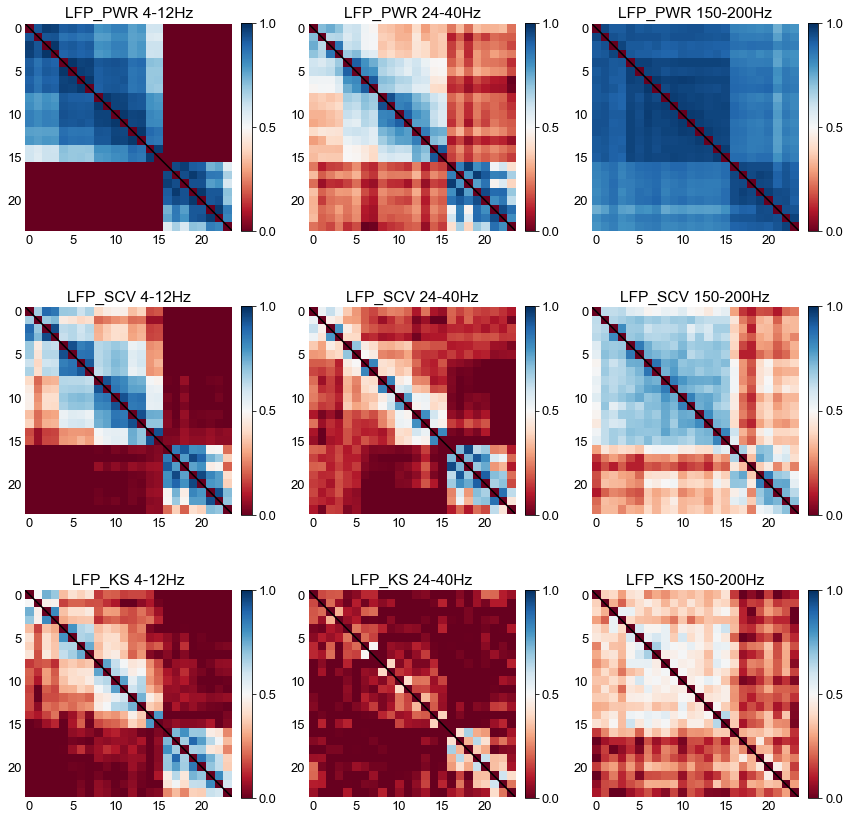

In [71]:
plt.figure(figsize=(12,12))
for freq in range(3):
    for ind in range(3):
        rho, pv = utils.corrcoefp(lfpstats_rw[:,sub_inds,freq,ind])
        plt.subplot(3,3,ind*3+freq+1)
        utils.corr_plot(rho,bounds=[0,1])
        plt.title(labels[ind+2]+' %i-%iHz'%filt_bands[freq])
plt.tight_layout()

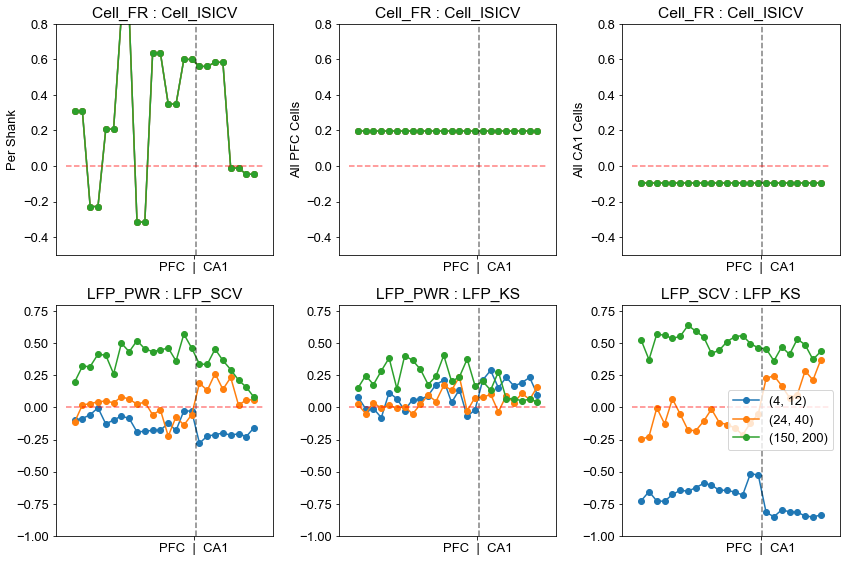

In [72]:
# FR-ISI
plt.figure(figsize=(12,8))
for ind in range(3):
    plt.subplot(2,3,ind+1)
    plot_corrs(all_corr[ind],f1=0,f2=1,labels=labels, YL=(-0.5, 0.8))
    plt.ylabel(corr_labels[ind])

plt.subplot(2,3,4)
plot_corrs(all_corr[0],f1=2,f2=3,labels=labels, YL=(-1, 0.8))
plt.subplot(2,3,5)
plot_corrs(all_corr[0],f1=2,f2=4,labels=labels, YL=(-1, 0.8))
plt.subplot(2,3,6)
plot_corrs(all_corr[0],f1=3,f2=4,labels=labels, YL=(-1, 0.8))
plt.legend(filt_bands)
plt.tight_layout()

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


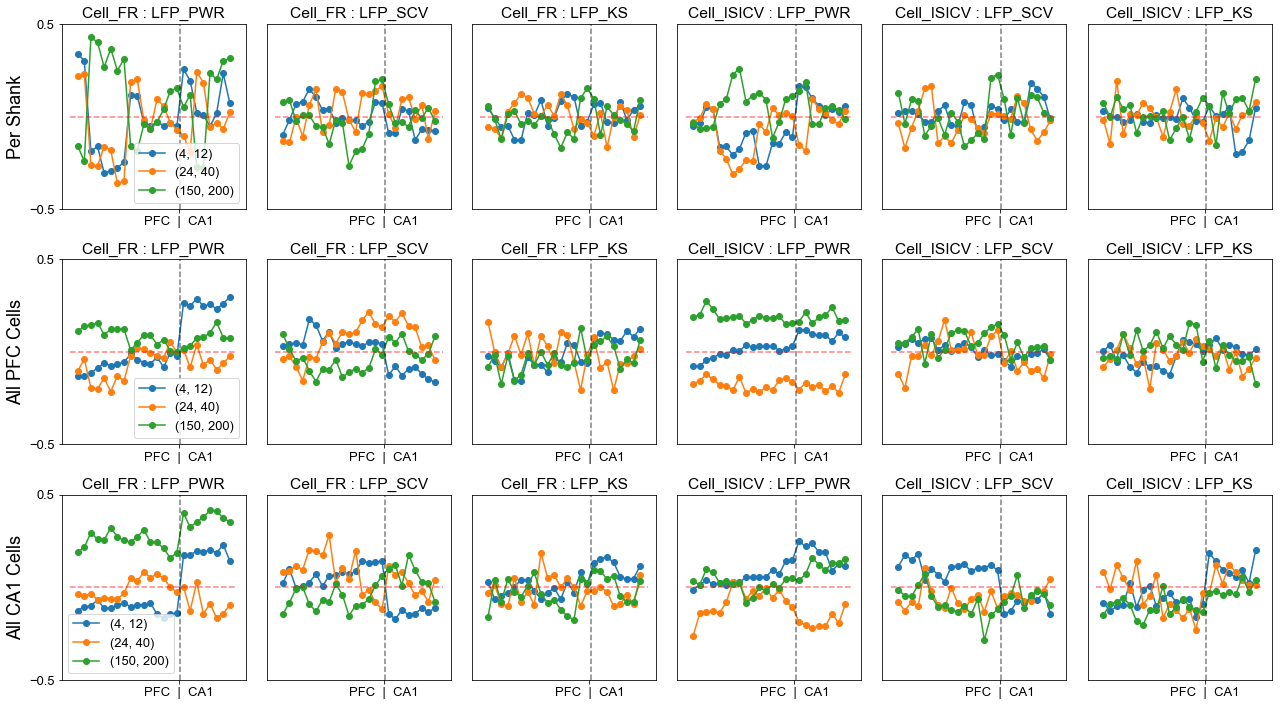

In [73]:
plt.figure(figsize=(18,10))
for corr_ind in range(3):
    for i,f1 in enumerate([0,1]):
        for j,f2 in enumerate([2,3,4]):
#             plt.subplot(3,4,i*2+j+1+corr_ind*4)
            plt.subplot(3,6,i*3+j+1+corr_ind*6)
            plot_corrs(all_corr[corr_ind],f1,f2,labels)
            plt.yticks([])

    plt.subplot(3,6,1+corr_ind*6)
    plt.ylabel(corr_labels[corr_ind], fontsize=18)
    plt.yticks([-0.5,0.5])
    plt.legend(filt_bands)
    plt.tight_layout()

234
-----
(4, 12)
           FR       ISI       PWR       SCV
FR   1.000000  0.314844  0.036078 -0.145670
ISI  0.314844  1.000000 -0.016788 -0.040092
PWR  0.036078 -0.016788  1.000000 -0.214271
SCV -0.145670 -0.040092 -0.214271  1.000000
-----
(24, 40)
           FR       ISI       PWR       SCV
FR   1.000000  0.314844 -0.125684 -0.106248
ISI  0.314844  1.000000  0.009047  0.001989
PWR -0.125684  0.009047  1.000000  0.031905
SCV -0.106248  0.001989  0.031905  1.000000
-----
(150, 200)
           FR       ISI       PWR       SCV
FR   1.000000  0.314844 -0.111881 -0.063903
ISI  0.314844  1.000000 -0.040705  0.009621
PWR -0.111881 -0.040705  1.000000  0.204808
SCV -0.063903  0.009621  0.204808  1.000000


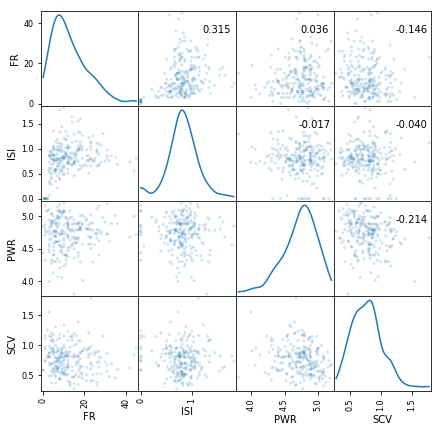

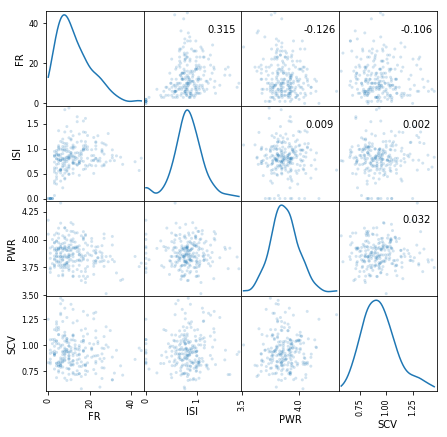

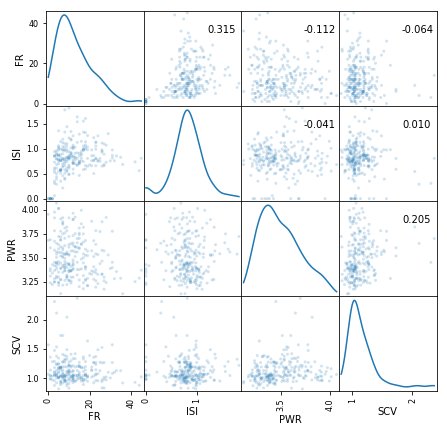

In [105]:
sub_inds = np.arange(len(t_win))
#sub_inds = rest_inds
sub_inds = task_inds
sub_inds = sub_inds[::2]

sh=0
spkstats = spkstats_shank[sh,:,:]
lfpstats = lfpstats_rw[sh,:,:,:]

print(len(sub_inds))
for freq in range(3):
    d_list=[
        spkstats[sub_inds,0],
        spkstats[sub_inds,2], 
        np.log10(lfpstats[sub_inds,freq,0]), 
        lfpstats[sub_inds,freq,1]
    ]
    df = pd.DataFrame(np.array(d_list).T, columns=labels)
    corr = df.corr(method='spearman').as_matrix()
    axes = pdplt.scatter_matrix(df, alpha=0.2, figsize=(7, 7), diagonal='kde');
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        # label with correlation coefficient
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
    print('-----')
    print(filt_bands[freq])
    print(df.corr(method='spearman'))